In [2]:
import pandas as pd
import kagglehub
import numpy as np

In [3]:

path = kagglehub.dataset_download("harrywang/wine-dataset-for-clustering")

wine_df =  pd.read_csv(path + "/wine-clustering.csv")

In [4]:
wine_df

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [6]:
wine_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=wine_df)
wine_emb_pca = PCA(n_components=2).fit_transform(wine_df)

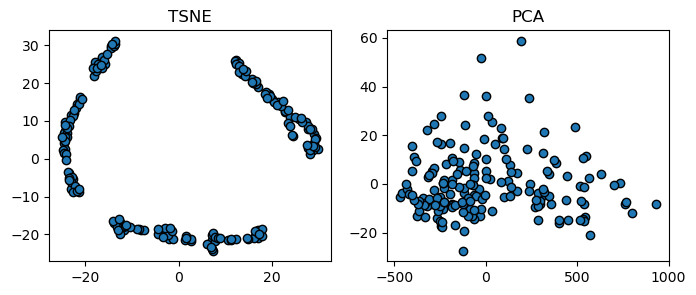

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(wine_emb_tsne[:, 0], wine_emb_tsne[:, 1], edgecolors='k')
axes[0].set_title("TSNE")
axes[1].scatter(wine_emb_pca[:, 0], wine_emb_pca[:, 1], edgecolors='k')
axes[1].set_title("PCA")

plt.savefig("C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/wine_pca_tsne.png", dpi=120)

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaled_data = StandardScaler().fit_transform(wine_df.to_numpy())

In [10]:
scaled_data.shape

(178, 13)

In [11]:
def hierarchical_clustering(distance_matrix):
    # Определяем количество кластеров
    num_clusters = len(distance_matrix)
    # Инициализируем список мощностей кластеров
    cluster_powers = list(np.ones(num_clusters, dtype=np.int64))

    # Идентификаторы кластеров
    cluster_ids = list(range(num_clusters))
    # Словарь для хранения парных расстояний
    pairwise_distances = {}
    # Словарь для хранения мощностей всех кластеров
    all_cluster_powers = {c_id: p for (c_id, p) in zip(cluster_ids, cluster_powers)}
    
    # Пока количество кластеров больше 2
    while num_clusters > 2:
        # Находим индексы минимального расстояния
        min_index = np.argmin(distance_matrix)
        idx_i, idx_j = np.unravel_index(min_index, distance_matrix.shape)

        # Получаем мощности кластеров
        power_i = cluster_powers[idx_i]
        power_j = cluster_powers[idx_j]

        # Расстояние между кластерами
        distance = distance_matrix[idx_i, idx_j]  # R(u, v)
        pairwise_distances[(cluster_ids[idx_i], cluster_ids[idx_j])] = distance

        # Удаляем кластеры с максимальным идентификатором
        max_cluster_id = max(cluster_ids)
        for idx in sorted([idx_i, idx_j], reverse=True):
            del cluster_powers[idx]
            del cluster_ids[idx]

        # Вычисляем веса для новых кластеров
        alpha_u = (np.array(cluster_powers) + power_i) / (np.array(cluster_powers) + power_i + power_j)
        alpha_v = (np.array(cluster_powers) + power_j) / (np.array(cluster_powers) + power_i + power_j)
        beta = -np.array(cluster_powers) / (np.array(cluster_powers) + power_i + power_j)

        # Удаляем строки, соответствующие объединяемым кластерам
        distance_matrix = np.delete(distance_matrix, [idx_i, idx_j], axis=0)
        # Вычисляем новое расстояние между кластерами
        new_distances = alpha_u * distance_matrix[:, idx_i] + alpha_v * distance_matrix[:, idx_j] + beta * distance

        # Применяем формулу Уорда для вычисления новых расстояний
        new_distances = np.sqrt(alpha_u * np.square(distance_matrix[:, idx_i]) + 
                                alpha_v * np.square(distance_matrix[:, idx_j]) + beta * (distance**2))

        # Удаляем столбцы, соответствующие объединяемым кластерам
        distance_matrix = np.delete(distance_matrix, [idx_i, idx_j], axis=1)

        # Создаем новую матрицу расстояний
        new_distance_matrix = np.zeros((num_clusters - 1, num_clusters - 1))
        new_distance_matrix[:-1, :-1] = distance_matrix
        new_distance_matrix[-1, -1] = np.inf  # Устанавливаем бесконечное расстояние для нового кластера
        new_distance_matrix[-1, :-1] = new_distances.T
        new_distance_matrix[:-1, -1] = new_distances

        distance_matrix = new_distance_matrix

        # Обновляем мощности и идентификаторы кластеров
        cluster_powers.append(power_i + power_j)
        cluster_ids.append(max_cluster_id + 1)
        all_cluster_powers[max_cluster_id + 1] = power_i + power_j
        num_clusters -= 1

    # Получаем минимальное расстояние для финальных кластеров
    final_distance = np.min(distance_matrix).reshape((1, 1))
    pairwise_distances[(cluster_ids[0], cluster_ids[1])] = final_distance[0, 0]
    cluster_powers = [sum(cluster_powers)]
    cluster_ids = [max(cluster_ids) + 1]
    
    return pairwise_distances, all_cluster_powers


In [12]:
from scipy.spatial.distance import cdist

In [13]:
distances = cdist(scaled_data, scaled_data)
np.fill_diagonal(distances, np.inf)

In [14]:
import time

In [15]:
start_time = time.time()

pairwise_distances, all_clusters_power = hierarchical_clustering(distances)

end_time = time.time()
execution_time = end_time - start_time

print(f"Время выполнения: {execution_time:.4f} секунд")

Время выполнения: 0.0423 секунд


In [16]:
print(f'pairwise_distances = {pairwise_distances}\n all_clusters_power = {all_clusters_power}')

pairwise_distances = {(9, 47): 1.1641136694837706, (131, 133): 1.1916023832934053, (11, 12): 1.2093557078355408, (15, 53): 1.2255104571302595, (92, 107): 1.2453879844639868, (34, 37): 1.2684183793961963, (0, 20): 1.2878931632008224, (16, 17): 1.2917937003073956, (164, 172): 1.3004837878902993, (22, 29): 1.3356668693833789, (40, 56): 1.3444777230616134, (104, 116): 1.3521748977881223, (23, 24): 1.3626878815408092, (27, 38): 1.3653111017349047, (140, 142): 1.3674017387896762, (63, 98): 1.3840254382392718, (26, 57): 1.3867639646823555, (111, 125): 1.4379470729323005, (163, 170): 1.4445809483188425, (148, 174): 1.4578879758475727, (82, 87): 1.4713249481522577, (90, 91): 1.478092494681999, (139, 162): 1.4865254293521635, (10, 31): 1.5132365663969833, (138, 165): 1.555336805684991, (147, 160): 1.5794248791884475, (5, 18): 1.5809816754828727, (155, 173): 1.5849029273448725, (106, 189): 1.5905358562665555, (167, 171): 1.5971626078252843, (80, 97): 1.6080136101712024, (35, 190): 1.6292130999839

In [17]:
linkage_rows = [
    [k[0], k[1], v, all_clusters_power[k[0]] + all_clusters_power[k[1]]]
    for k, v in pairwise_distances.items()
]
linkage_matrix = np.array(linkage_rows)



In [18]:
linkage_matrix

array([[  9.        ,  47.        ,   1.16411367,   2.        ],
       [131.        , 133.        ,   1.19160238,   2.        ],
       [ 11.        ,  12.        ,   1.20935571,   2.        ],
       [ 15.        ,  53.        ,   1.22551046,   2.        ],
       [ 92.        , 107.        ,   1.24538798,   2.        ],
       [ 34.        ,  37.        ,   1.26841838,   2.        ],
       [  0.        ,  20.        ,   1.28789316,   2.        ],
       [ 16.        ,  17.        ,   1.2917937 ,   2.        ],
       [164.        , 172.        ,   1.30048379,   2.        ],
       [ 22.        ,  29.        ,   1.33566687,   2.        ],
       [ 40.        ,  56.        ,   1.34447772,   2.        ],
       [104.        , 116.        ,   1.3521749 ,   2.        ],
       [ 23.        ,  24.        ,   1.36268788,   2.        ],
       [ 27.        ,  38.        ,   1.3653111 ,   2.        ],
       [140.        , 142.        ,   1.36740174,   2.        ],
       [ 63.        ,  98

In [19]:
unique_clusters = set()
duplicates = set()
duplicate_rows = []

for row in linkage_matrix:
    if (row[0] in unique_clusters) or (row[1] in unique_clusters):
        duplicates.add(row[0])
        duplicates.add(row[1])
        duplicate_rows.append(row)
    else:
        unique_clusters.add(row[0])
        unique_clusters.add(row[1])

if duplicates:
    print("Найдены дублирующиеся кластеры в linkage_matrix:")
    for dup in duplicates:
        print(f"Дублирующийся кластер: {dup}")
    print("Строки с дубликатами:")
    for dup_row in duplicate_rows:
        print(dup_row)
else:
    print("Нет дублирующихся кластеров.")

Нет дублирующихся кластеров.


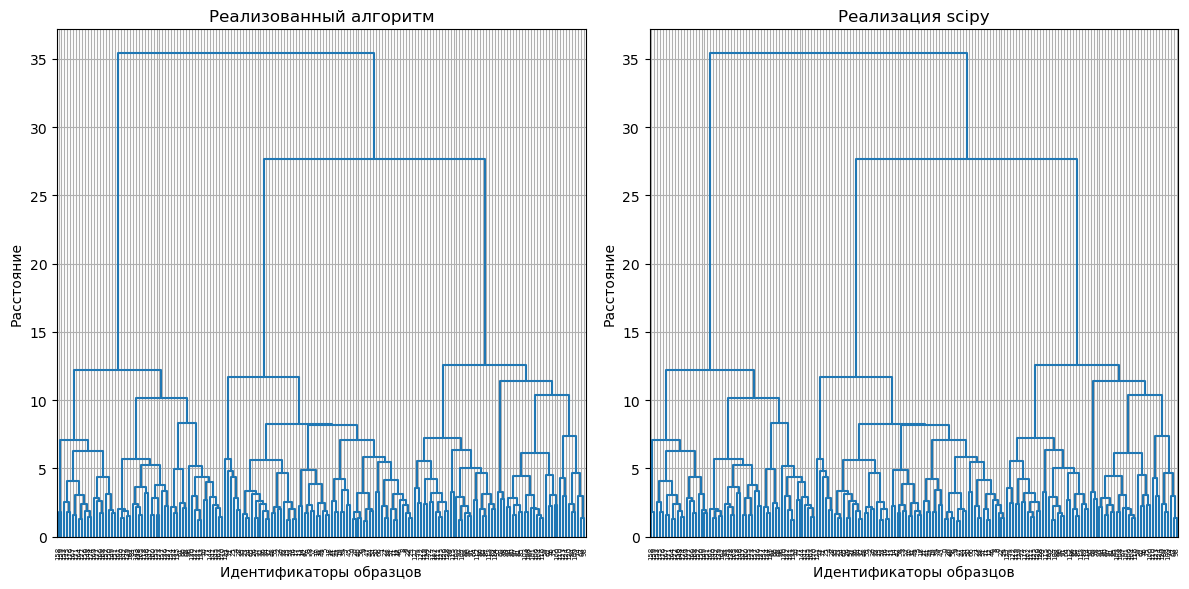

In [20]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy as sch

figure, subplots = plt.subplots(1, 2, figsize=(12, 6))

dendrogram_custom = sch.dendrogram(linkage_matrix, ax=subplots[0], color_threshold=0)
subplots[0].set_title("Реализованный алгоритм")
subplots[0].set_xlabel("Идентификаторы образцов")
subplots[0].set_ylabel("Расстояние")
subplots[0].grid(True)

linkage_result = sch.linkage(scaled_data, method='ward')
dendrogram_scipy = sch.dendrogram(linkage_result, ax=subplots[1], color_threshold=0)
subplots[1].set_title("Реализация scipy")
subplots[1].set_xlabel("Идентификаторы образцов")
subplots[1].set_ylabel("Расстояние")
subplots[1].grid(True)

output_path = r"C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/wine_dendrogram.png"
plt.tight_layout()
plt.savefig(output_path)

plt.show()


In [21]:
def em(data, num_clusters, max_iterations=100):
    
    if isinstance(data, np.ndarray):
        dataset = data
    else:
        dataset = data.to_numpy()
   
    weights = np.full(num_clusters, 1 / num_clusters) # Инициализация весов
    centers = dataset[np.random.choice(dataset.shape[0], num_clusters, replace=False)] # Случайный выбор начальных центров
    variances = np.random.random((num_clusters, dataset.shape[1])) # Инициализация дисперсий
    variances = np.where(variances == 0.0, 1e-8, variances) # Замена нулевых значений для избежания деления на ноль
    previous_labels = np.array([])
    current_labels = np.array([])

    for iteration in range(max_iterations):
        responsibilities = np.zeros((dataset.shape[0], num_clusters)) # Инициализация матрицы вероятностей принадлежности
        
       
        for cluster in range(num_clusters): # Вычисление вероятностей для каждого кластера
            prob_density = (1 / (np.sqrt(2 * np.pi) * np.sqrt(variances[cluster]))) * \
                           np.exp(-((dataset - centers[cluster]) ** 2) / (2 * variances[cluster]))
            responsibilities[:, cluster] = weights[cluster] * np.prod(prob_density, axis=1)

       
        total_responsibilities = responsibilities.sum(axis=1, keepdims=True) # Нормализация вероятностей
        total_responsibilities[total_responsibilities == 0] = 1  # Избегаем деления на ноль
        responsibilities /= total_responsibilities

       
        weights = responsibilities.mean(axis=0) # Обновление весов
       
        centers = np.dot(responsibilities.T, dataset) / responsibilities.sum(axis=0).reshape(-1, 1) # Обновление центров 
       
        variances = np.zeros((num_clusters, dataset.shape[1])) # Обновление дисперсий 

        for cluster in range(num_clusters):
            deviations = dataset - centers[cluster]  # Вычисление отклонений от центров
            variances[cluster] = np.dot(responsibilities[:, cluster], deviations**2) / responsibilities[:, cluster].sum() # Обновление дисперсий

        variances = np.where(variances == 0.0, 1e-8, variances) # Замена нулевых значений на малые числа

        current_labels = np.argmax(responsibilities, axis=1) # Определение меток

        if np.array_equal(previous_labels, current_labels): # Проверка на сходимость
            break
        else:
            previous_labels = current_labels.copy()

    clusters = [[] for _ in range(num_clusters)]
    for index in range(dataset.shape[0]):
        clusters[current_labels[index]].append(dataset[index])

    return clusters, centers, current_labels


Время выполнения кастомной функции: 0.0070 секунд
Время выполнения sklearn функции: 0.2030 секунд
Среднее внутрикластерное расстояние (кастомная функция): 3.5139
Среднее межкластерное расстояние (кастомная функция): 5.5483
Среднее внутрикластерное расстояние (sklearn функция): 3.5662
Среднее межкластерное расстояние (sklearn функция): 5.5632


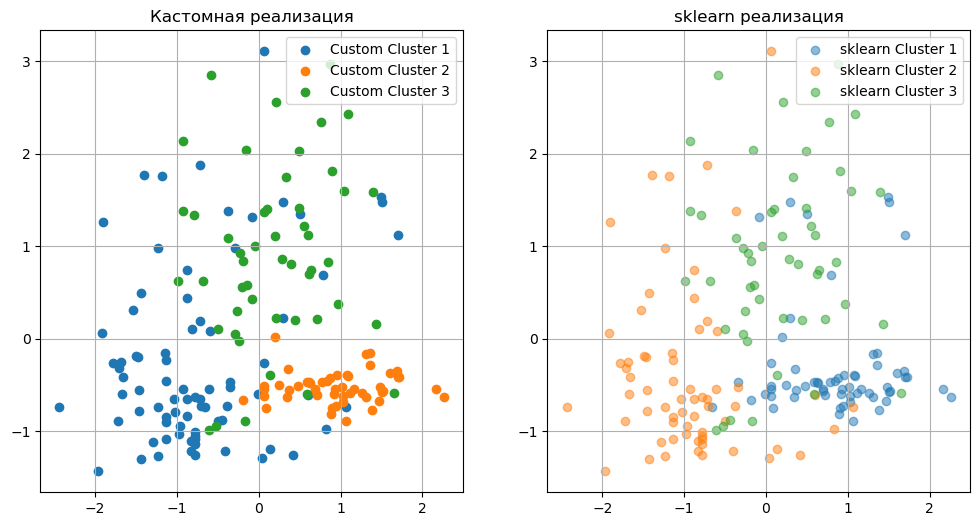

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
import time
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

start_time = time.time()
clusters_custom, centroids_custom, labels_custom = em(scaled_data, 3, 30)
end_time = time.time()
execution_time_custom = end_time - start_time
print(f"Время выполнения кастомной функции: {execution_time_custom:.4f} секунд")

start_time = time.time()
gmm = GaussianMixture(n_components=3, max_iter=30)
gmm.fit(scaled_data)
labels_sci = gmm.predict(scaled_data)
centroids_sci = gmm.means_
clusters_sci = [scaled_data[labels_sci == i] for i in range(3)]
end_time = time.time()
execution_time_sci = end_time - start_time
print(f"Время выполнения sklearn функции: {execution_time_sci:.4f} секунд")

def calculate_distances(clusters):
    intra_cluster_distances = []
    inter_cluster_distances = []
    
    for cluster in clusters:
        if len(cluster) > 1:
            intra_cluster_distances.append(np.mean(pairwise_distances(cluster)))
    
    all_points = np.vstack(clusters)
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_cluster_distances.append(np.mean(pairwise_distances(clusters[i], clusters[j])))
    
    return np.mean(intra_cluster_distances), np.mean(inter_cluster_distances)

mean_intra_custom, mean_inter_custom = calculate_distances(clusters_custom)
print(f"Среднее внутрикластерное расстояние (кастомная функция): {mean_intra_custom:.4f}")
print(f"Среднее межкластерное расстояние (кастомная функция): {mean_inter_custom:.4f}")

mean_intra_sci, mean_inter_sci = calculate_distances(clusters_sci)
print(f"Среднее внутрикластерное расстояние (sklearn функция): {mean_intra_sci:.4f}")
print(f"Среднее межкластерное расстояние (sklearn функция): {mean_inter_sci:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i, cluster in enumerate(clusters_custom):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Custom Cluster {i + 1}')
centroids_custom = np.array(centroids_custom)
#plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], s=300, c='red', marker='X', label='Custom Centroids')
plt.title('Кастомная реализация')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for i, cluster in enumerate(clusters_sci):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 0], cluster[:, 1], marker='o', label=f'sklearn Cluster {i + 1}', alpha=0.5)
centroids_sci = np.array(centroids_sci)
# plt.scatter(centroids_sci[:, 0], centroids_sci[:, 1], s=300, c='blue', marker='X', label='sklearn Centroids')
plt.title('sklearn реализация')
plt.legend()
plt.grid()

output_path = r"C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/wine_em_comparison.png"
plt.savefig(output_path)
plt.show()


In [23]:
def dbscan(data_frame, epsilon, min_samples):

    if isinstance(data_frame, np.ndarray):
        data = data_frame
    else:
        data = data_frame.to_numpy()  
    num_points = data.shape[0]  # Получаем количество точек в данных
    labels = np.zeros(num_points, dtype=int)  # Инициализация меток кластеров
    cluster_id = 0  # Счетчик кластеров
    
    for point_index in range(num_points):  # Проходим по всем точкам
        if labels[point_index] > 0:  # Если точка уже помечена, пропускаем
            continue

        
        distances = np.linalg.norm(data[point_index] - data, axis=1)  # Вычисляем расстояния от текущей точки до всех остальных
       
        neighbors = np.where(distances <= epsilon)[0]  # Находим соседей в пределах радиуса epsilon
        
        if len(neighbors) < min_samples:  # Если соседей меньше, чем min_samples
            labels[point_index] = -1  # Помечаем как шум
        else:
            cluster_id += 1  # Увеличиваем счетчик кластеров
            labels[point_index] = cluster_id  # Присваиваем метку кластеру
            
            k = 0  # Индекс для обхода соседей
            while k < len(neighbors):  # Обрабатываем всех соседей
                current_index = neighbors[k]  # Текущий сосед
                
                if labels[current_index] == -1:  # Если сосед был помечен как шум
                    labels[current_index] = cluster_id  # Присваиваем ему метку кластера
                
                if labels[current_index] == 0:  # Если сосед еще не помечен
                    labels[current_index] = cluster_id  # Присваиваем метку кластера
                    
                    distance = np.linalg.norm(data[current_index] - data, axis=1) # Вычисляем расстояния от текущего соседа до всех остальных 
                   
                    neighbor_neighbors = np.where(distance <= epsilon)[0]  # Находим соседей текущего соседа 
                    
                    if len(neighbor_neighbors) >= min_samples:  # Если у соседа достаточно соседей
                        neighbors = np.append(neighbors, neighbor_neighbors)  # Добавляем их к текущим соседям
                
                k += 1  # Переходим к следующему соседу

    clusters = [[] for _ in range(cluster_id)]  # Список для кластеров
    noise_points = []  # Список для шумовых точек
    for i in range(num_points):  # Проходим по всем точкам
        if labels[i] == -1:  # Если точка шум
            noise_points.append(data[i])  # Добавляем в шум, используя массив NumPy
        else:
            clusters[labels[i] - 1].append(data[i])  # Добавляем в соответствующий кластер
    return clusters, noise_points  # Возвращаем кластеры и шум


In [24]:
start_time = time.time()

clusters, noise_points = dbscan(scaled_data, epsilon=2.5, min_samples=10)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time:.4f} секунд")

Время выполнения: 0.0040 секунд


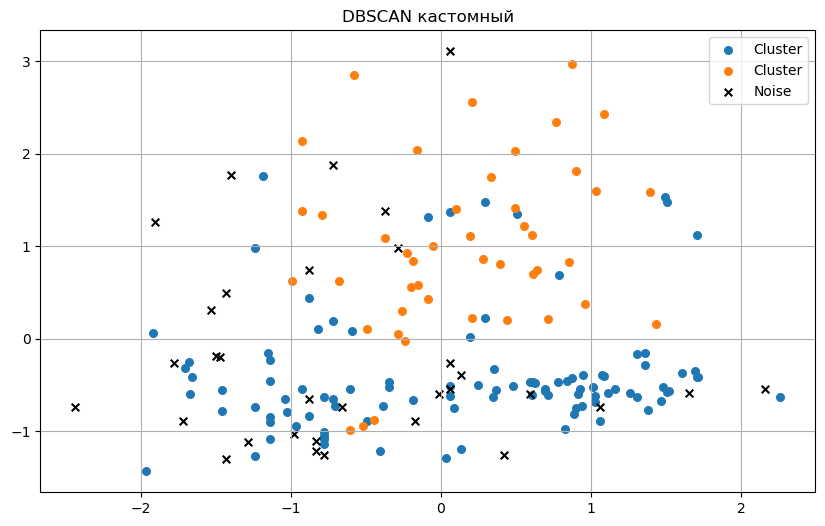

In [25]:
plt.figure(figsize=(10, 6))

for cluster in clusters:
    cluster_array = np.array(cluster)
    plt.scatter(cluster_array[:, 0], cluster_array[:, 1], label='Cluster', s=30)

if noise_points:
    noise_array = np.array(noise_points)
    plt.scatter(noise_array[:, 0], noise_array[:, 1], color='black', label='Noise', s=30, marker='x')

plt.title('DBSCAN кастомный')
plt.legend()
plt.grid()
plt.show()

Время выполнения кастомной функции DBSCAN: 0.0060 секунд
Время выполнения sklearn функции DBSCAN: 0.0040 секунд
Среднее внутрикластерное расстояние (кастомная функция): 3.5622
Среднее межкластерное расстояние (кастомная функция): 5.6303
Среднее внутрикластерное расстояние (sklearn функция): 3.5622
Среднее межкластерное расстояние (sklearn функция): 5.6303


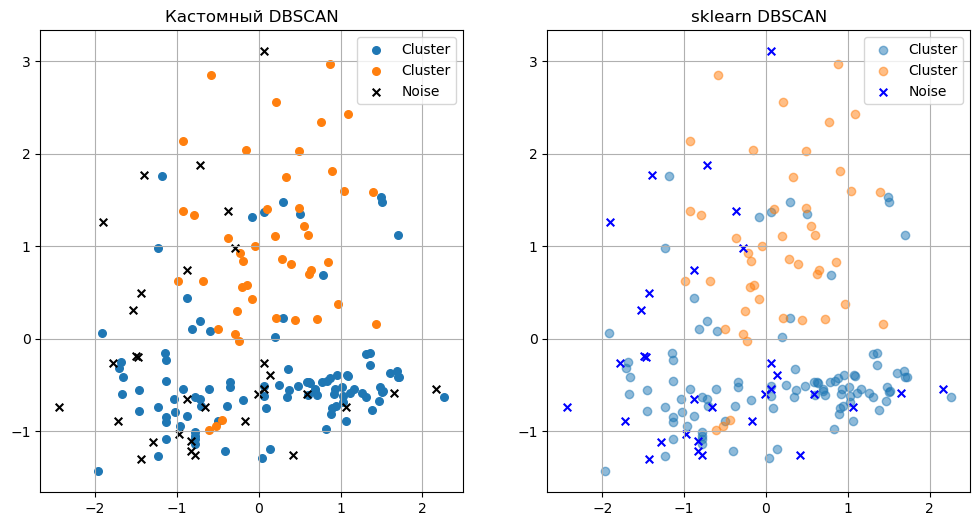

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN as sklearnDBSCAN
from sklearn.metrics import pairwise_distances
import time
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

start_time = time.time()
clusters_custom, noise_points_custom = dbscan(scaled_data, epsilon=2.5, min_samples=10)
end_time = time.time()
execution_time_custom = end_time - start_time
print(f"Время выполнения кастомной функции DBSCAN: {execution_time_custom:.4f} секунд")

start_time = time.time()
dbscan_sci = sklearnDBSCAN(eps=2.5, min_samples=10)
labels_sci = dbscan_sci.fit_predict(scaled_data)

clusters_sci = [scaled_data[labels_sci == i] for i in range(len(set(labels_sci)) - (1 if -1 in labels_sci else 0))]
noise_points_sci = scaled_data[labels_sci == -1] if -1 in labels_sci else []

end_time = time.time()
execution_time_sci = end_time - start_time
print(f"Время выполнения sklearn функции DBSCAN: {execution_time_sci:.4f} секунд")

def calculate_distances(clusters):
    intra_cluster_distances = []
    inter_cluster_distances = []
    
    for cluster in clusters:
        if len(cluster) > 1:
            intra_cluster_distances.append(np.mean(pairwise_distances(cluster)))
    
    all_points = np.vstack(clusters)
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_cluster_distances.append(np.mean(pairwise_distances(clusters[i], clusters[j])))
    
    return np.mean(intra_cluster_distances), np.mean(inter_cluster_distances)

mean_intra_custom, mean_inter_custom = calculate_distances(clusters_custom)
print(f"Среднее внутрикластерное расстояние (кастомная функция): {mean_intra_custom:.4f}")
print(f"Среднее межкластерное расстояние (кастомная функция): {mean_inter_custom:.4f}")

mean_intra_sci, mean_inter_sci = calculate_distances(clusters_sci)
print(f"Среднее внутрикластерное расстояние (sklearn функция): {mean_intra_sci:.4f}")
print(f"Среднее межкластерное расстояние (sklearn функция): {mean_inter_sci:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster in clusters_custom:
    cluster_array = np.array(cluster)
    plt.scatter(cluster_array[:, 0], cluster_array[:, 1], label='Cluster', s=30)

if noise_points_custom:
    noise_array = np.array(noise_points_custom)
    plt.scatter(noise_array[:, 0], noise_array[:, 1], color='black', label='Noise', s=30, marker='x')

plt.title('Кастомный DBSCAN')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for cluster in clusters_sci:
    cluster_array = np.array(cluster)
    plt.scatter(cluster_array[:, 0], cluster_array[:, 1], marker='o', label='Cluster', alpha=0.5)
if noise_points_sci.size > 0:
    plt.scatter(noise_points_sci[:, 0], noise_points_sci[:, 1], color='blue', label='Noise', s=30, marker='x')
plt.title('sklearn DBSCAN')
plt.legend()
plt.grid()

# Сохранение и отображ
output_path = r"C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/wine_dbscan_comparison.png"
plt.savefig(output_path)
plt.show()

In [27]:

path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
mall_df =  pd.read_csv(path + "/Mall_Customers.csv")

In [28]:
mall_df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [29]:
mall_df["Gender"] = mall_df["Gender"].replace(['Male', 'Female'], [0, 1])

C:\Users\pavel\AppData\Local\Temp\ipykernel_17460\2586835888.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mall_df["Gender"] = mall_df["Gender"].replace(['Male', 'Female'], [0, 1])


In [30]:
mall_emb_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=15).fit_transform(X=mall_df)
mall_emb_pca = PCA(n_components=2).fit_transform(mall_df)

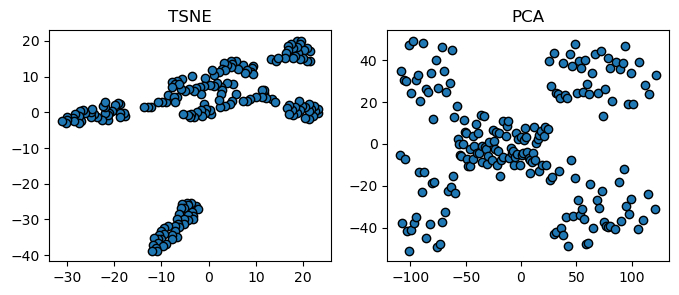

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].scatter(mall_emb_tsne[:, 0], mall_emb_tsne[:, 1], edgecolors='k')
axes[0].set_title("TSNE")
axes[1].scatter(mall_emb_pca[:, 0], mall_emb_pca[:, 1], edgecolors='k')
axes[1].set_title("PCA")

plt.savefig("C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/mall_pca_tsne.png", dpi=120)

In [32]:
scaled_mall_data = StandardScaler().fit_transform(mall_df)

In [33]:
distances = cdist(scaled_mall_data, scaled_mall_data)
np.fill_diagonal(distances, np.inf)

In [34]:
start_time = time.time()

pairwise_distances, all_clusters_power = hierarchical_clustering(distances)

end_time = time.time()
execution_time = end_time - start_time

print(f"Время выполнения: {execution_time:.4f} секунд")

Время выполнения: 0.0450 секунд


In [35]:
linkage_rows = [
    [k[0], k[1], v, all_clusters_power[k[0]] + all_clusters_power[k[1]]]
    for k, v in pairwise_distances.items()
]
linkage_matrix = np.array(linkage_rows)


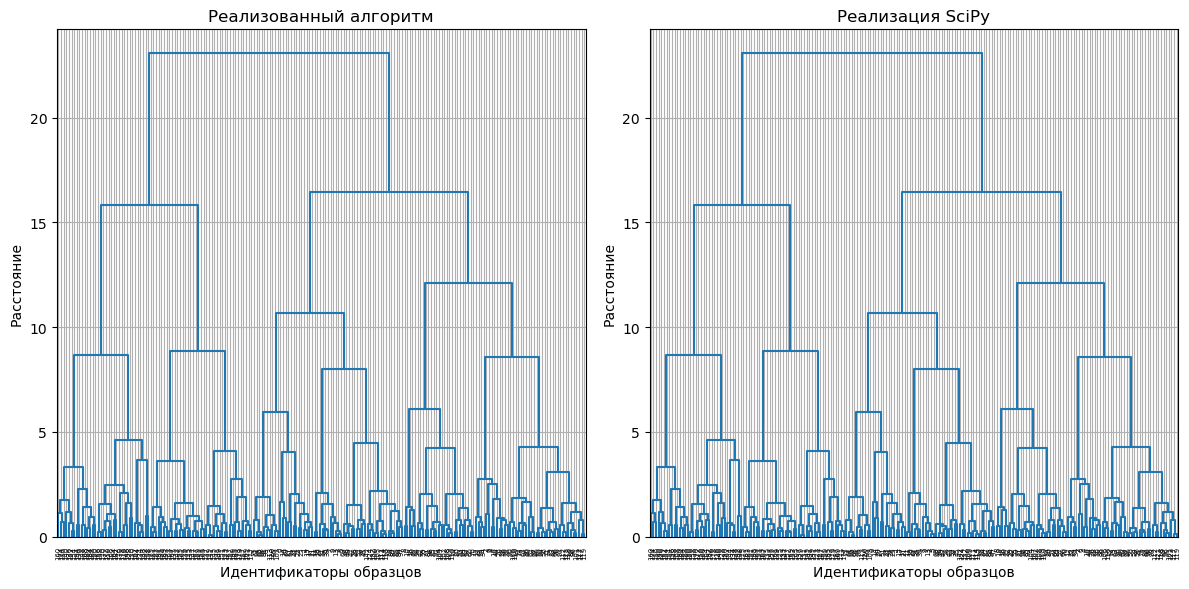

In [36]:
figure, subplots = plt.subplots(1, 2, figsize=(12, 6))

dendrogram_custom = sch.dendrogram(linkage_matrix, ax=subplots[0], color_threshold=0)
subplots[0].set_title("Реализованный алгоритм")
subplots[0].set_xlabel("Идентификаторы образцов")
subplots[0].set_ylabel("Расстояние")
subplots[0].grid(True)

linkage_result = sch.linkage(scaled_mall_data, method='ward')
dendrogram_scipy = sch.dendrogram(linkage_result, ax=subplots[1], color_threshold=0)
subplots[1].set_title("Реализация SciPy")
subplots[1].set_xlabel("Идентификаторы образцов")
subplots[1].set_ylabel("Расстояние")
subplots[1].grid(True)

output_path = r"C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/mall_dendrogram.png"
plt.tight_layout()
plt.savefig(output_path)

plt.show()


In [37]:
scaled_mall_data.shape

(200, 5)

Время выполнения кастомной функции: 0.0030 секунд
Время выполнения sklearn функции: 0.0110 секунд
Среднее внутрикластерное расстояние (кастомная функция): 2.0335
Среднее межкластерное расстояние (кастомная функция): 3.2743
Среднее внутрикластерное расстояние (sklearn функция): 1.6051
Среднее межкластерное расстояние (sklearn функция): 3.9779


c:\Users\pavel\anaconda3\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


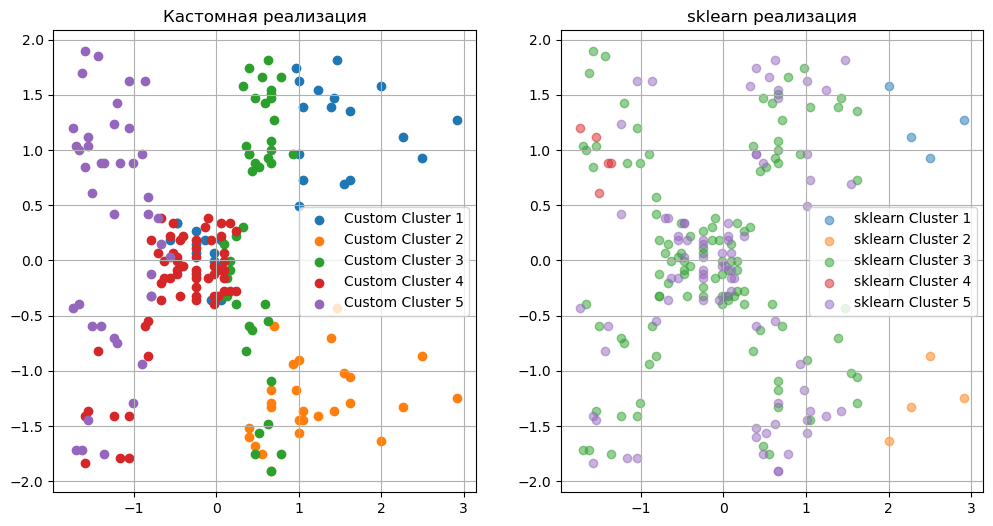

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
import time
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

clusters_count = 5
max_iter = 4
start_time = time.time()
clusters_custom, centroids_custom, labels_custom = em(scaled_mall_data, clusters_count, max_iter)
end_time = time.time()
execution_time_custom = end_time - start_time
print(f"Время выполнения кастомной функции: {execution_time_custom:.4f} секунд")

start_time = time.time()
gmm = GaussianMixture(n_components=clusters_count, max_iter=max_iter)
gmm.fit(scaled_mall_data)
labels_sci = gmm.predict(scaled_mall_data)
centroids_sci = gmm.means_
clusters_sci = [scaled_mall_data[labels_sci == i] for i in range(clusters_count) if len(scaled_mall_data[labels_sci == i]) > 0]
end_time = time.time()
execution_time_sci = end_time - start_time
print(f"Время выполнения sklearn функции: {execution_time_sci:.4f} секунд")

def calculate_distances(clusters):
    intra_cluster_distances = []
    inter_cluster_distances = []
    
    for cluster in clusters:
        if len(cluster) > 1:
            intra_cluster_distances.append(np.mean(pairwise_distances(cluster)))
    
    all_points = np.vstack([cluster for cluster in clusters if len(cluster) > 0])
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_cluster_distances.append(np.mean(pairwise_distances(clusters[i], clusters[j])))
    
    return np.mean(intra_cluster_distances), np.mean(inter_cluster_distances)

mean_intra_custom, mean_inter_custom = calculate_distances(clusters_custom)
print(f"Среднее внутрикластерное расстояние (кастомная функция): {mean_intra_custom:.4f}")
print(f"Среднее межкластерное расстояние (кастомная функция): {mean_inter_custom:.4f}")

mean_intra_sci, mean_inter_sci = calculate_distances(clusters_sci)
print(f"Среднее внутрикластерное расстояние (sklearn функция): {mean_intra_sci:.4f}")
print(f"Среднее межкластерное расстояние (sklearn функция): {mean_inter_sci:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i, cluster in enumerate(clusters_custom):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 3], cluster[:, 4], label=f'Custom Cluster {i + 1}')
centroids_custom = np.array(centroids_custom)
# plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], s=300, c='red', marker='X', label='Custom Centroids')
plt.title('Кастомная реализация')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for i, cluster in enumerate(clusters_sci):
    cluster = np.array(cluster)
    plt.scatter(cluster[:, 3], cluster[:, 4], marker='o', label=f'sklearn Cluster {i + 1}', alpha=0.5)
centroids_sci = np.array(centroids_sci)
# plt.scatter(centroids_sci[:, 0], centroids_sci[:, 1], s=300, c='blue', marker='X', label='sklearn Centroids')
plt.title('sklearn реализация')
plt.legend()
plt.grid()

output_path = r"C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/mall_em_comparison.png"
plt.savefig(output_path)
plt.show()


Время выполнения кастомной функции DBSCAN: 0.0040 секунд
Время выполнения sklearn функции DBSCAN: 0.0020 секунд
Среднее внутрикластерное расстояние (кастомная функция): 1.1675
Среднее межкластерное расстояние (кастомная функция): 2.8152
Среднее внутрикластерное расстояние (sklearn функция): 1.1675
Среднее межкластерное расстояние (sklearn функция): 2.8152


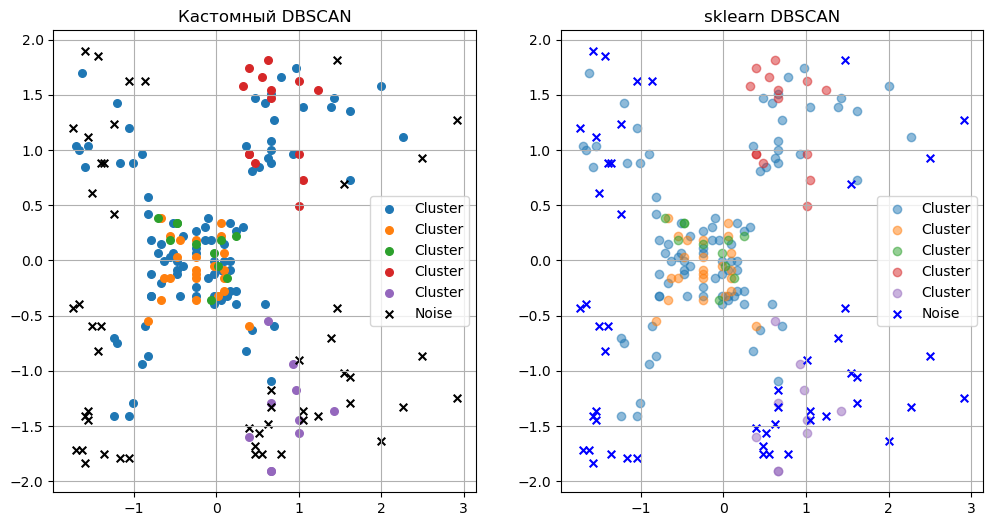

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN as sklearnDBSCAN
from sklearn.metrics import pairwise_distances
import time
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

epsilon=1
min_samples = 10

start_time = time.time()
clusters_custom, noise_points_custom = dbscan(scaled_mall_data, epsilon=epsilon, min_samples=min_samples)
end_time = time.time()
execution_time_custom = end_time - start_time
print(f"Время выполнения кастомной функции DBSCAN: {execution_time_custom:.4f} секунд")

start_time = time.time()
dbscan_sci = sklearnDBSCAN(eps=epsilon, min_samples=min_samples)
labels_sci = dbscan_sci.fit_predict(scaled_mall_data)

clusters_sci = [scaled_mall_data[labels_sci == i] for i in range(len(set(labels_sci)) - (1 if -1 in labels_sci else 0))]
noise_points_sci = scaled_mall_data[labels_sci == -1] if -1 in labels_sci else []

end_time = time.time()
execution_time_sci = end_time - start_time
print(f"Время выполнения sklearn функции DBSCAN: {execution_time_sci:.4f} секунд")

def calculate_distances(clusters):
    intra_cluster_distances = []
    inter_cluster_distances = []
    
    for cluster in clusters:
        if len(cluster) > 1:
            intra_cluster_distances.append(np.mean(pairwise_distances(cluster)))
    
    all_points = np.vstack(clusters)
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            inter_cluster_distances.append(np.mean(pairwise_distances(clusters[i], clusters[j])))
    
    return np.mean(intra_cluster_distances), np.mean(inter_cluster_distances)

mean_intra_custom, mean_inter_custom = calculate_distances(clusters_custom)
print(f"Среднее внутрикластерное расстояние (кастомная функция): {mean_intra_custom:.4f}")
print(f"Среднее межкластерное расстояние (кастомная функция): {mean_inter_custom:.4f}")

mean_intra_sci, mean_inter_sci = calculate_distances(clusters_sci)
print(f"Среднее внутрикластерное расстояние (sklearn функция): {mean_intra_sci:.4f}")
print(f"Среднее межкластерное расстояние (sklearn функция): {mean_inter_sci:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster in clusters_custom:
    cluster_array = np.array(cluster)
    plt.scatter(cluster_array[:, 3], cluster_array[:, 4], label='Cluster', s=30)

if noise_points_custom:
    noise_array = np.array(noise_points_custom)
    plt.scatter(noise_array[:, 3], noise_array[:, 4], color='black', label='Noise', s=30, marker='x')

plt.title('Кастомный DBSCAN')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for cluster in clusters_sci:
    cluster_array = np.array(cluster)
    plt.scatter(cluster_array[:, 3], cluster_array[:, 4], marker='o', label='Cluster', alpha=0.5)
if noise_points_sci.size > 0:
    plt.scatter(noise_points_sci[:, 3], noise_points_sci[:, 4], color='blue', label='Noise', s=30, marker='x')
plt.title('sklearn DBSCAN')
plt.legend()
plt.grid()

output_path = r"C:/Users/pavel/Desktop/fall-24/students/pn-pren/Lab1/img/mall_dbscan_comparison.png"
plt.savefig(output_path)
plt.show()